In [1]:
import os
import numpy as np # linear algebra
import scipy
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage import segmentation
from skimage.filters    import gaussian, median
from skimage.measure import *
from sklearn.cluster import *
from skimage.segmentation import *
from skimage.exposure import *
import matplotlib.patches as patches
from skimage.transform import *
from matplotlib.path import Path

import peakutils
from peakutils.plot import plot as pplot
import string
import csv

In [2]:
# return cropped image
def crop_border(image):
    x1,x2 = 120,571
    y1,y2 = 60,531
    image = image[y1:y2,x1:x2]
    return resize(image,[451,441])

In [3]:
def crop_border_ref(image):
    x1,x2 = 203,644
    y1,y2 = 87,538
    return image[y1:y2,x1:x2]

In [5]:
IMAGE_BICEP_TRAIN = './tendon_images/Bicep_Train'
IMAGE_SUP_TRAIN = './tendon_images/Sup_Train'
IMAGE_BICEP = './tendon_images/Biceps'
IMAGE_SUP   = './tendon_images/Supraspinatus'

def load_images_names_from_folder(folder):
    images = []
    name = []
    train = []
    train_name = []
    for filename in os.listdir(folder):
        if "ID" in filename and 'REF' not in filename:
            
            img = imread(os.path.join(folder,filename))
            images.append(crop_border(img))
            name.append(filename)
  
            # if there are training images, load them
            ref = filename.replace('.jpg','')+'_REF_SEL.jpg'
            if ref in os.listdir(folder):
                img = imread(os.path.join(folder,ref))
                train.append(crop_border_ref(img))
                train_name.append(ref)
                
    return [images,train,name,train_name]

[images,train,names,train_name] = load_images_names_from_folder(IMAGE_BICEP_TRAIN)


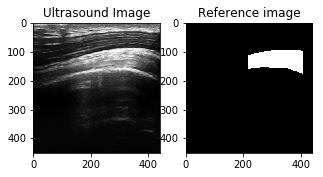

In [6]:
%matplotlib inline
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (5,5))
ax1.imshow(images[2])
ax1.set_title('Ultrasound Image')
if train:
    ax2.imshow(train[2])
    ax2.set_title('Reference image')


In [22]:
# extract x value to find where the ROI should start
# this looks at the very top of the image to find the imprint of two metal bars on the skin
# these are shown as peaks in the rows and we can localize an x coordinate for the region from these. 
# Bicep tendon has bars on the left, sup on the right
# for the Bicep the ROI is then a set distance from the bars, for the sup it varies between patients

def set_x_ROI(image,offset):
    image = gaussian(image,sigma=4)
    y = []
    for i in range(image.shape[1]): 
        y.insert(i,np.mean(image[0:10,i]))
        
    x = np.linspace(0, image.shape[1], image.shape[1])
    y = np.array(y)
    
    indexes = np.array(peakutils.indexes(y, thres=0.8, min_dist=20)) # there should be two peaks it returns
    x = ((indexes[1] - indexes[0]))  

    x = x + offset
    
    return x

In [24]:
# extract initial ROI by sliding window down to find maximum intensity 
# in thresholded image

def find_initial_ROI(image,init_x):
    maximum = 0
    max_x = init_x
    max_y = 50
    (x1,y1) = (init_x,50) # if there is a brighter region at top from skin then ignore
    length = 193 # from training
    width = 100
    (x2,y2) = (x1+length,y1+width)

    # shift down to find brightest region
    for j in range (image.shape[1] - width):
        x = x1
        y = y1 + j
        (x2,y2) = (x+length,y+width)
        temp = np.sum(image[y:y2, x:x2])
        if temp > maximum:
            maximum = temp
            max_x = x
            max_y = y

    return max_x,max_y                     

In [87]:
# fit contour on region based on window on maximum

def fit_contour(image,max_x,max_y,length,width):
    s = np.linspace(0, 2*np.pi, 400)
    x = (max_x + length/2) + length*np.cos(s)
    y = (max_y + width/2) + (width/2)*np.sin(s)
    init = np.array([x, y]).T
    
    snake = active_contour(image,init, bc ='fixed', alpha=1.5, beta=1.0, w_line=1, w_edge=1, gamma=0.1) 
    return snake

In [88]:
# fix x coordinates of snake to be maximum length

def fix_snake(snake,x,length):
    for val in snake:
        if val[0] < x:
            val[0] = x
        if val[0] > (x+length):
            val[0] = x+length
    return snake

In [89]:
# based on the snake coordinates, we can extract the maximim sized
# rectangle for the region

def ROI_from_snake(snake):
    s = snake
    x = []
    y = []
    top = []
    bottom = []

    for i,j in s:
        x.append(i)
        y.append(j)

    for i,j in s:
        if (i >= (min(x) + 10)) and (i <= (max(x) - 10)):
            if j > int(np.mean(y)):
                bottom.append(int(j))
            elif j < int(np.mean(y)):
                top.append(int(j))

    ymin = int(np.mean(y))
    ymax = int(np.mean(y))

    for i in range(100):
        ymin = ymin - 1
        if ymin in top:
            break

    for i in range(100):
        ymax = ymax + 1
        if ymax in bottom:
            break

    ROI = [[int(min(x)),ymin],[int(max(x)),ymax] ]

    #ROI = [[int(min(x)),max(top)],[max(x),max(bottom)] ]#[[min(x),max(top)],[max(x),min(bottom)] ]
    return ROI

In [90]:
# 1. Transform images by equalizing histogram and filtering
# 2. Then threshold the image to get the maximum
# 3. After the inital ROI is extracted based on the brightness
#    we fit a snake onto the thresholded image 
# 4. Cut the snake so it fits within in the desired length

# set values
thres_val = 0.97
length = 193 #2cm
width = 100
offset = 145 # 145 is about 1.5cm
    
c = [] # converted images
snake = [] 
ROI_xy = []
ROI = [] 
rect = []  # used for plotting
ROI_img = [] # used for F1 extraction
Precision = []
Recall = []
F1 = []

# filter and threshold
for i in range(len(images)):
    temp = images[i]
    temp = equalize_hist(temp)
    temp = gaussian(temp,sigma=2)
    x = np.max(temp,2)
    x[x<thres_val]=0
    c.insert(i,x)
      
# fit snake        
for i in range(len(c)):
    ROI_x = set_x_ROI(images[i],offset)
    [x,y] = find_initial_ROI(c[i],ROI_x)
    
    ROI_xy.insert(i,[x,y])
    
    contour = fit_contour(c[i],ROI_xy[i][0],ROI_xy[i][1],length,width)
    snake.insert(i,contour)
    snake[i] = fix_snake(snake[i],ROI_xy[i][0],length)
    
    region = ROI_from_snake(snake[i])
    ROI.insert(i,region)


In [45]:
# if final ROI wanted on plot
for i in range(len(ROI)):
    r= patches.Rectangle((ROI[i][0][0],ROI[i][0][1]),length,(ROI[i][1][1] - ROI[i][0][1]),linewidth=1,edgecolor='r',facecolor='none')
    rect.insert(i,r)

In [34]:
# if original rectangle wanted on plot
for i in range(len(c)):
    r= patches.Rectangle((ROI_xy[i][0],ROI_xy[i][1]),length,width,linewidth=1,edgecolor='r',facecolor='none')
    rect.insert(i,r)     

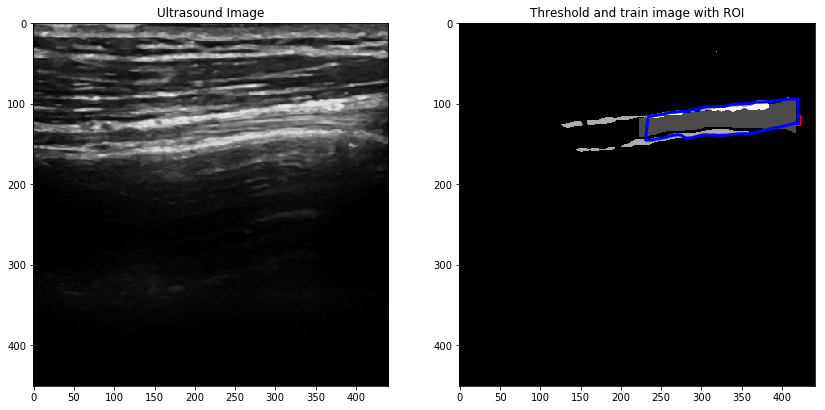

In [91]:
# if final ROI wanted on plot
for i in range(len(ROI)):
    r= patches.Rectangle((ROI[i][0][0],ROI[i][0][1]),length,(ROI[i][1][1] - ROI[i][0][1]),linewidth=1,edgecolor='r',facecolor='none')
    rect.insert(i,r)
    
# plot one set of images in greater detail
%matplotlib inline
fig, ((ax1,ax2)) = plt.subplots(1,2, figsize = (14,14))

idx = 1

# first image
ax1.imshow(images[idx], cmap = 'gray')
ax1.set_title('Ultrasound Image')
ax2.imshow(c[idx], cmap = 'gist_earth')

ax2.plot(snake[idx][:, 0], snake[idx][:, 1], '-b', lw=3)
ax2.add_artist(rect[idx])
ax2.imshow(train[idx], alpha=0.3, cmap='Blues')

ax2.set_title('Threshold and train image with ROI')

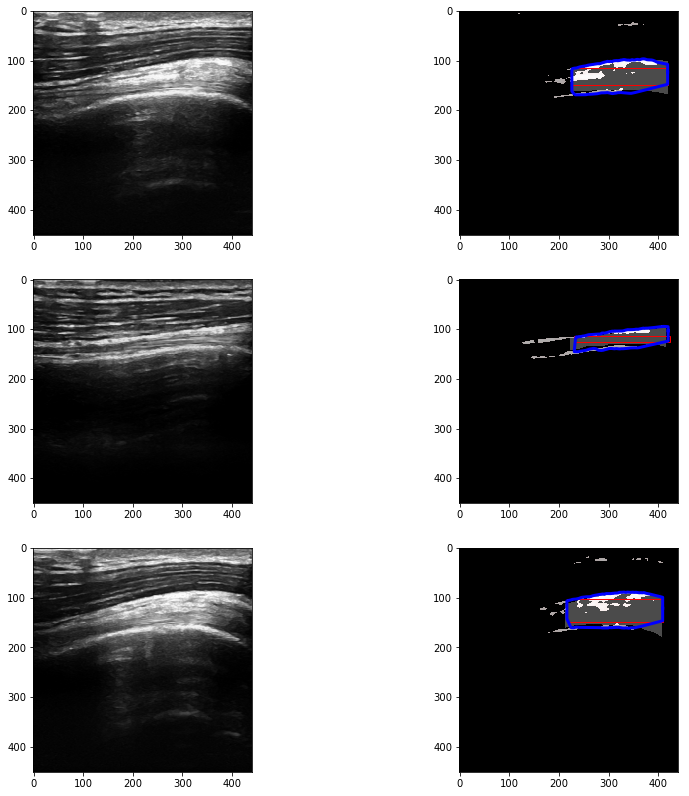

In [92]:
for i in range(len(ROI)):
    r= patches.Rectangle((ROI[i][0][0],ROI[i][0][1]),length,(ROI[i][1][1] - ROI[i][0][1]),linewidth=1,edgecolor='r',facecolor='none')
    rect.insert(i,r)

%matplotlib inline
fig, ((ax1,ax2),(ax4,ax5),(ax7,ax8)) = plt.subplots(3,2, figsize = (14,14))

ax1.imshow(images[0], cmap = 'gray')
ax2.imshow(c[0], cmap = 'gist_earth')

ax2.plot(snake[0][:, 0], snake[0][:, 1], '-b', lw=3)
ax2.add_patch(rect[0])

ax4.imshow(images[1], cmap = 'gray')
ax5.imshow(c[1], cmap = 'gist_earth')

ax5.plot(snake[1][:, 0], snake[1][:, 1], '-b', lw=3)
ax5.add_patch(rect[1])

ax7.imshow(images[2], cmap = 'gray')
ax8.imshow(c[2], cmap = 'gist_earth')

ax8.plot(snake[2][:, 0], snake[2][:, 1], '-b', lw=3)
ax8.add_patch(rect[2])

ax2.imshow(train[0], alpha=0.3)
ax5.imshow(train[1], alpha=0.3)
ax8.imshow(train[2], alpha=0.3)

In [93]:
# Find F1, precision, and recall scores for the images
# this is done by converting the ROI region and the training image
# to a boolean matrix and checking the overlaps. 

# build image
for idx in range(len(c)):
    image = c[idx] 
    x1 = ROI[idx][0][0] 
    x2 = ROI[idx][1][0] 
    y1 = ROI[idx][0][1] 
    y2 = ROI[idx][1][1] 

    # build rectangle path around ROI
    p = Path([[x1,y1],[x2,y1],[x2,y2],[x1,y2]])
    #p = Path(np.array(snake[idx]))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (p.contains_points([[j,i]])): 
                    image[i,j] = 255
            else:
                image[i,j] = 0
                
    ROI_img.insert(idx,image)

    
# find f1 score 
for idx in range(len(c)):
    t = np.max(train[idx],2).astype(bool).ravel() # convert to bool vector
    img = ROI_img[idx].astype(bool).ravel()

    tp = 0.0
    fn = 0.0
    tn = 0.0
    fp = 0.0

    for i in range(len(t)):
        if ((t[i] == True) and (img[i] == True)):
            tp = tp +1
        if ((t[i] == True) and (img[i] == False)):
            fn = fn +1
        if ((t[i] == False) and (img[i] == False)):
            tn = tn +1
        if ((t[i] == False) and (img[i] == True)):
            fp = fp +1

    print tp, fp, fn, tn

    precision = tp/ (tp + fp)
    recall    = tp/(tp + fn)
    
    Precision.insert(idx,precision)
    Recall.insert(idx,recall)

    f1 = 2 * (precision*recall)  / (precision + recall)
    F1.insert(idx,f1)

    print precision, recall, f1
    print

6916.0 68.0 5577.0 186330.0
0.990263459336 0.553590010406 0.710170970889

2198.0 94.0 4773.0 191826.0
0.958987783595 0.315306268828 0.474576271186

8798.0 126.0 4919.0 185048.0
0.985880770955 0.641393890792 0.777174153085



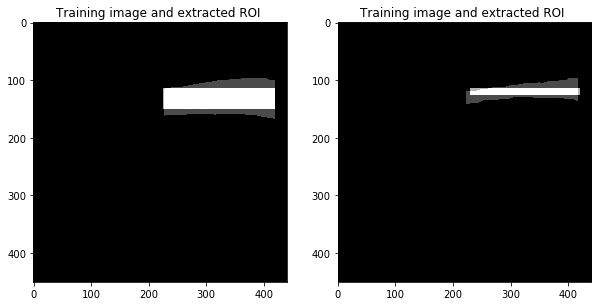

In [94]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,10))
idx = 0
# first image
ax1.imshow(ROI_img[idx], cmap = 'gray')
ax1.imshow(train[idx],alpha=0.3)
ax1.set_title('Training image and extracted ROI ')

ax2.imshow(ROI_img[1], cmap = 'gray')
ax2.imshow(train[1],alpha=0.3)
ax2.set_title('Training image and extracted ROI ')

In [70]:
# Save the data to a csv file
label = ['name','ROIx1','ROIy1','ROIx2','ROIy2','tendon_width','F1','Prec','Recall']
data = []

for i in range(len(names)):
    x = [names[i].replace('.jpg',''),int(ROI[i][0][0]),
         int(ROI[i][0][1]),int(ROI[i][1][0]),int(ROI[i][1][1]),
        int(ROI[i][1][1] - ROI[i][0][1]), round(F1[i],2), round(Precision[i],2), round(Recall[i],2) ]
    data.insert(i,x)

# write label and data    
with open('Bicep_Output.csv', 'w') as csvfile3:
    datawriter = csv.writer(csvfile3, delimiter=',')
    datawriter.writerow(label)
    for data in data:      
        datawriter.writerow(data)